In [109]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px


In [110]:
from SCTransform import SCTransform
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import tifffile

In [111]:
data = 'PlanariaDv2/'

Configure some display stuff for scanpy

In [112]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
#sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=[15,15])

In [113]:
mask_img = tifffile.imread(data+'Mask.tif')

# Load data, explore adata

In [114]:
adata=sc.read_csv(data+'ss_counts.csv')
bdata = sc.AnnData(np.transpose(adata.X))
bdata.obs.index = adata.var.index
bdata.var.index = adata.obs.index

In [115]:
adata = bdata

In [116]:
pos_df=pd.read_csv(data+'/coords.csv')

In [117]:
pos_df['IntX'] = np.round(pos_df['x']).astype(int)
pos_df['IntY'] = np.round(pos_df['y']).astype(int)

In [118]:
mask = (mask_img[pos_df['IntX'], pos_df['IntY']]>1)

In [119]:
pos_df = pos_df[mask]
adata = adata[mask,:].copy()

In [120]:
adata.X = sparse.csr_matrix(adata.X)

In [121]:
mapping_df=pd.read_csv('sgene.csv')

mapping_df.loc[mapping_df['Alias'].isna(),'Alias'] = mapping_df.loc[mapping_df['Alias'].isna(),'Smed ID']

adata.var.index = adata.var.merge(mapping_df, right_on = 'Smed ID', left_index=True)['Alias']

In [122]:
adata.var_names_make_unique()

Load the gene read matrix (gene_img), the file with the gene names in it (df_genenames), and the bead position file (pos_df)

In [123]:
adata_sct = SCTransform(adata,
                        min_cells=5,
                        gmean_eps=1,
                        n_genes=2000,
                        n_cells=None, #use all cells
                        bin_size=500,
                        bw_adjust=3,
                        inplace=False)

In [124]:
hvadata = adata_sct.copy()

In [125]:
adata

AnnData object with n_obs × n_vars = 11450 × 30183

In [126]:
hvadata.X.data

array([ 6.576009  ,  2.3968582 ,  1.0023974 , ..., 19.536291  ,
        3.12735   ,  0.17612597], dtype=float32)

Now we will throw in a spatial filter, no sense in including the shmear

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [127]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [128]:
sc.pp.calculate_qc_metrics(hvadata, percent_top=None, log1p=False, inplace=True)

In [129]:
sc.pp.regress_out(hvadata, ['total_counts'])
sc.pp.scale(hvadata, max_value=10)

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:02:39)


# PCA

Do the pca, note that we are doing it on the new hvadata, which is the version with only highly variable genes

In [130]:
sc.tl.pca(hvadata, svd_solver='arpack')
hvadata.obsm['X_pca'].shape #Just to show where the PCA data is stored

computing PCA
    with n_comps=50
    finished (0:00:47)


(11450, 50)

Plot a scatterplot of the first and second PCA components

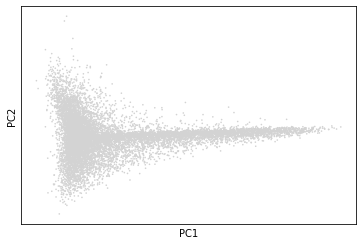

In [131]:
sc.pl.pca(hvadata)

Look at how much of the variance is explained by each PCA component, we will use this to decide how many principal components to keep

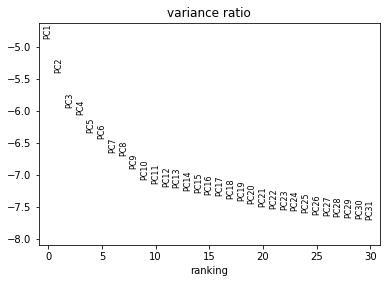

In [132]:
sc.pl.pca_variance_ratio(hvadata, log=True)

Now we compute connectivities between observations, I am not sure exactly what this does, I usually just do UMAP on the PCA results, but this uses the connectivities somehow

In [133]:
sc.pp.neighbors(hvadata, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


# UMAP

### UMAP and plotting

In [134]:
sc.tl.umap(hvadata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


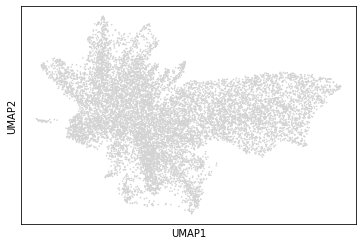

In [135]:
sc.pl.umap(hvadata)

### Clustering

In [136]:
sc.tl.leiden(hvadata)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


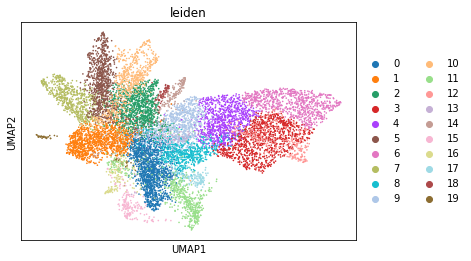

In [137]:
sc.pl.umap(hvadata, color=['leiden'])

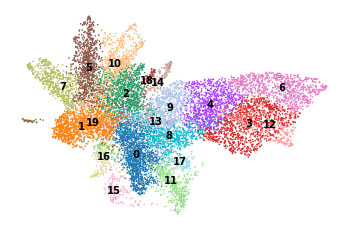

In [138]:
sc.pl.umap(hvadata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

## Find marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


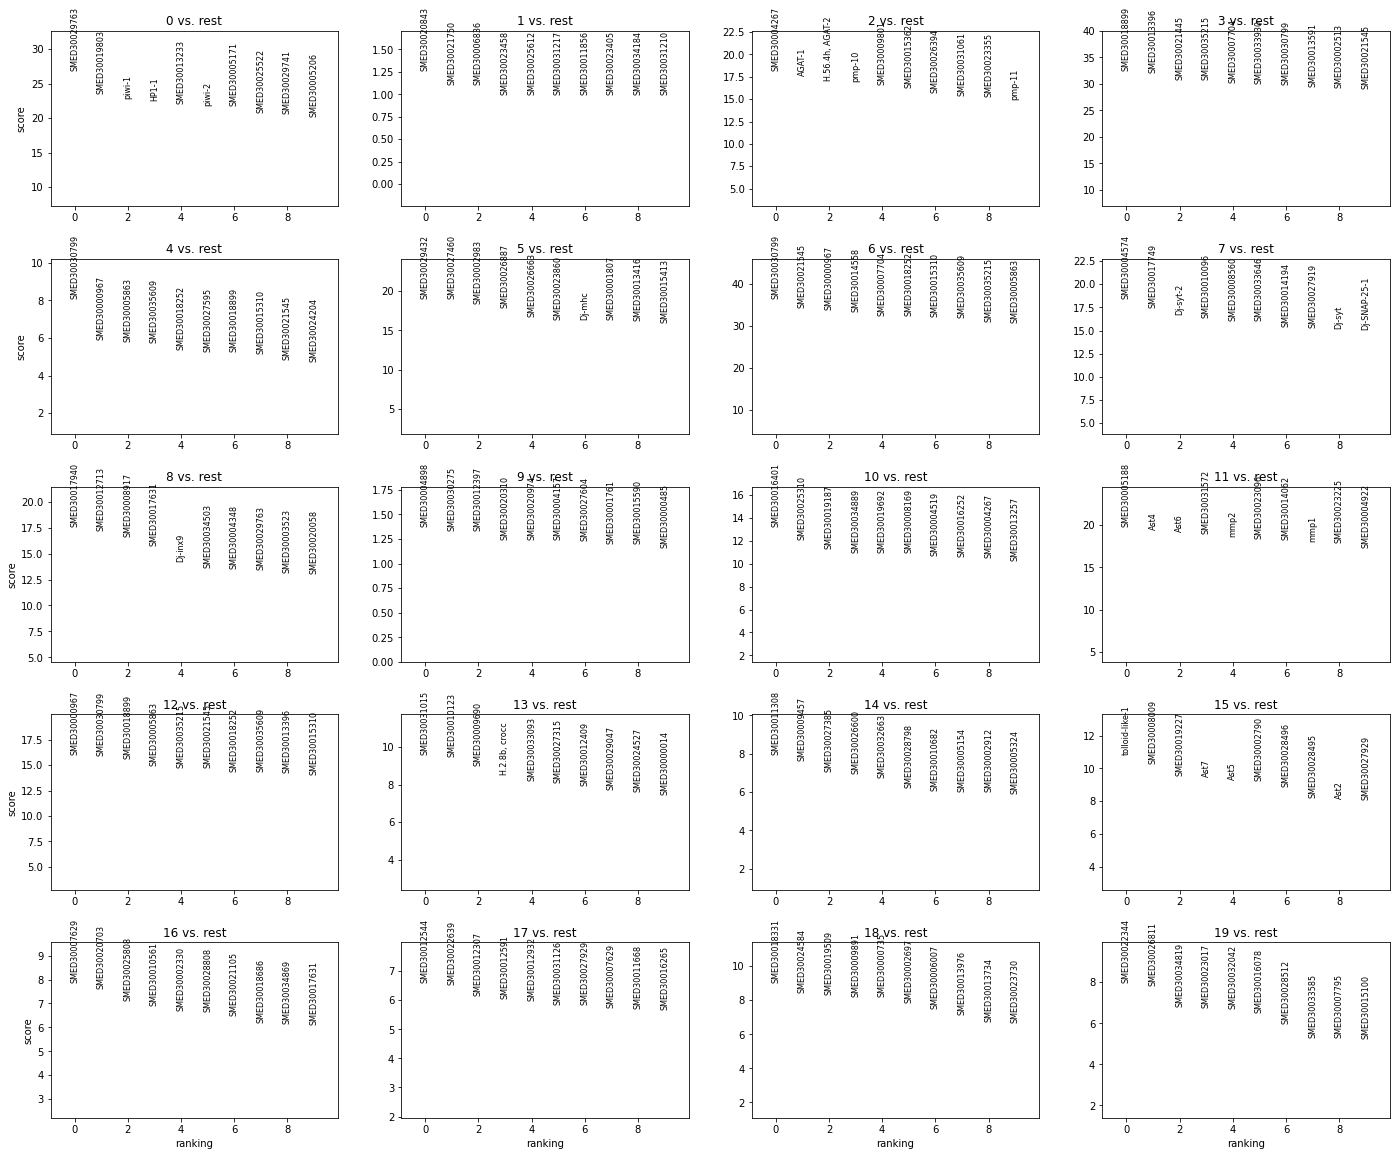

In [139]:
sc.tl.rank_genes_groups(hvadata, 'leiden', method='t-test', n_genes=1000)
sc.pl.rank_genes_groups(hvadata, n_genes=10, sharey=False)

In [140]:
hvadata.write(data+'hvadata.h5ad')
adata.write(data+'adata.h5ad')

In [141]:
pos_df.to_csv(data+'masked_coords.csv')

In [142]:
tdata= hvadata.copy()
sc.tl.umap(tdata, n_components=10)
np.save(data+'UMAP.npy', tdata.obsm['X_umap'])

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
